In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from scipy import stats
import networkx as nx
from networkx.algorithms import community

In [2]:
ego_alter_profiles = pd.read_csv("../Data/EgoAlterProfiles.txt", sep = '\t')

In [3]:
ego_alter_profiles

,ID,IsEgo,followers_count,friends_count,statuses_count,utc_offset,lang,created_at,protected
0,1,True,30.0,28,9.0,NaN,en,Wed Oct 26 03:30:32 +0000 2011,False
1,2,True,2.0,8,7.0,-14400.0,en,Mon Jul 27 20:46:32 +0000 2009,False
2,3,True,1.0,0,0.0,NaN,fr,Mon Apr 23 20:57:26 +0000 2012,False
3,4,True,3.0,3,68.0,NaN,en,Sun Feb 14 07:50:39 +0000 2010,False
4,5,True,65.0,118,748.0,NaN,fr,Mon Jun 11 14:17:06 +0000 2012,False
...,...,...,...,...,...,...,...,...,...
2516185,2516186,False,5129.0,191,403.0,10800.0,ar,Mon Jun 23 22:56:28 +0000 2014,False
2516186,2516187,False,6694.0,11,1523.0,-14400.0,en,Wed Jul 08 09:10:18 +0000 2009,False
2516187,2516188,False,6651.0,216,7141.0,-18000.0,en,Thu Jun 16 00:06:46 +0000 2011,False
2516188,2516189,False,21.0,59,33.0,NaN,en,Fri Nov 30 05:31:27 +0000 2012,False


In [4]:
ego_alter_profiles['lang'] = ego_alter_profiles['lang'].str.lower()
languages_count = ego_alter_profiles.groupby('lang')['ID'].count().reset_index(name = 'count')
small_language = languages_count[languages_count['count'] < 1000]['lang'].to_list()

languages = ego_alter_profiles[ ~ego_alter_profiles['lang'].isin(small_language) ].reset_index(drop = True)
languages = languages[['ID', 'followers_count', 'friends_count', 'statuses_count', 'lang']]
languages = languages.dropna()

western_language = ['cs', 'fi', 'sv', 'pl', 'da', 'ru', 'fr', 'ca', 'nl', 'de', 'pt', 'it', 'es', 'en-gb', 'en']
eastern_language = ['ar', 'id', 'tr', 'zh-tw', 'zh-cn', 'ja', 'th', 'ko', 'fil', 'msa']

def classify_lang(lang):
    if lang in western_language:
        return 'west'
    if lang in eastern_language:
        return 'east'

languages['area'] = languages['lang'].apply(classify_lang)

In [5]:
languages_stat = (languages.groupby('lang')[['followers_count', 'friends_count', 'statuses_count']]
.mean()
.reset_index())

languages_count_dict = dict(zip(languages_count['lang'], languages_count['count']))

def add_count(lang):
    return languages_count_dict[lang]

languages_stat['user_count'] = languages_stat['lang'].apply(add_count)
languages_stat.set_index('lang', inplace = True)
languages_stat.sort_values(by = 'user_count', inplace = True)

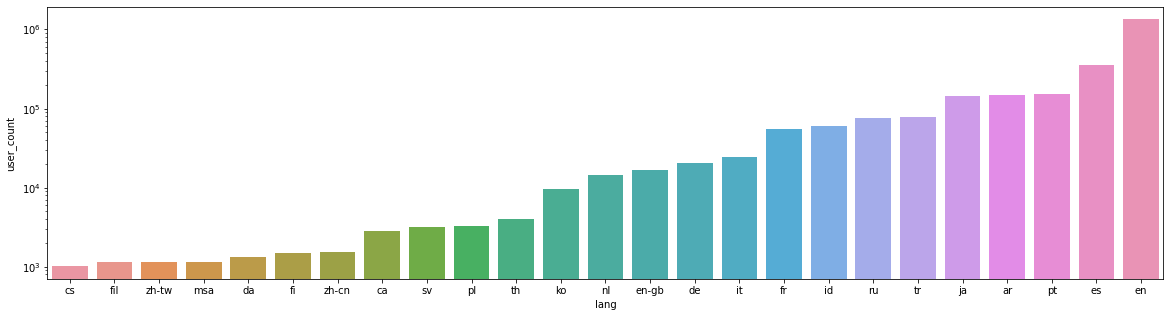

In [6]:
fig, ax = plt.subplots(figsize = (20, 5))

ax.set(yscale = 'log')
sns.barplot(x = languages_stat.index, y = languages_stat['user_count'], ax = ax)
plt.show()

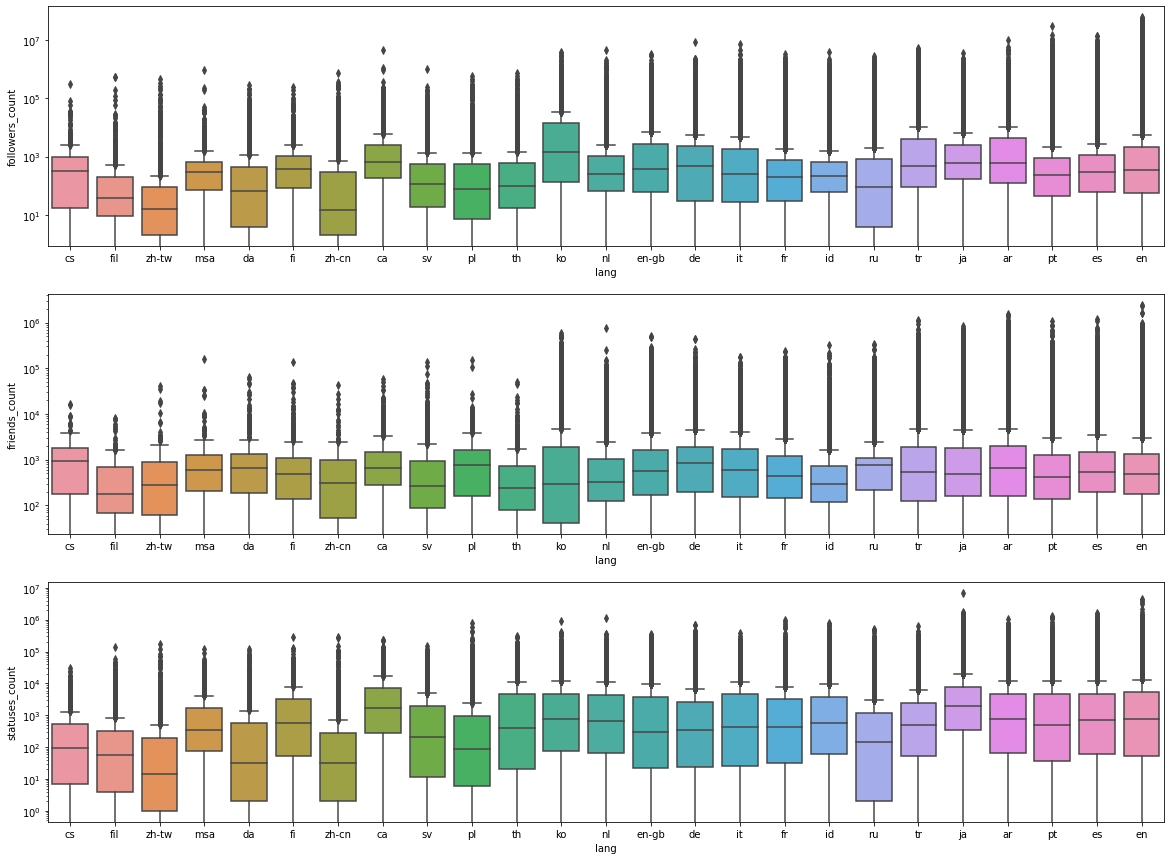

In [7]:
language_order = languages_stat.index.tolist()

fig, ax = plt.subplots(3, 1, figsize = (20, 15))

ax[0].set(yscale="log")
sns.boxplot(x = 'lang', y = 'followers_count', data = languages, order = language_order, ax = ax[0])

ax[1].set(yscale="log")
sns.boxplot(x = 'lang', y = 'friends_count', data = languages, order = language_order, ax = ax[1])

ax[2].set(yscale="log")
sns.boxplot(x = 'lang', y = 'statuses_count', data = languages, order = language_order, ax = ax[2])

plt.show()

<AxesSubplot:>

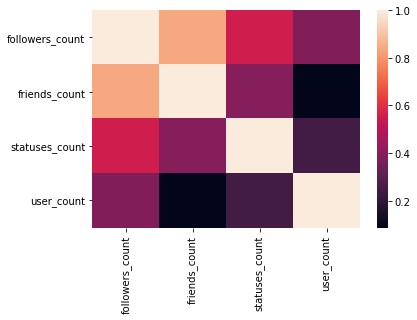

In [8]:
corr = languages_stat.corr()

sns.heatmap(corr)

0.38614098053612594
0.08694345670573422
0.2487860368472172


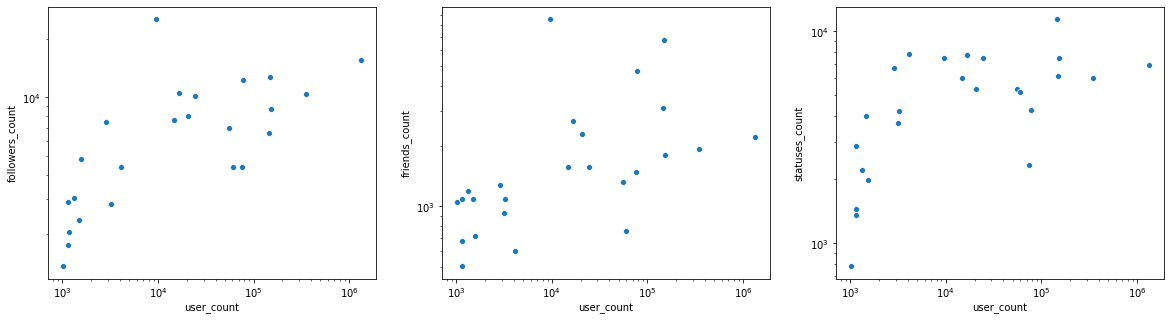

In [9]:
fig, ax = plt.subplots(1, 3, figsize = (20, 5))


ax[0].set(xscale="log", yscale='log')
sns.scatterplot(x = 'user_count', y = 'followers_count', data = languages_stat, ax = ax[0])

ax[1].set(xscale="log", yscale='log')
sns.scatterplot(x = 'user_count', y = 'friends_count', data = languages_stat, ax = ax[1])

ax[2].set(xscale="log", yscale='log')
sns.scatterplot(x = 'user_count', y = 'statuses_count', data = languages_stat, ax = ax[2])

print(languages_stat['user_count'].corr(languages_stat['followers_count']))
print(languages_stat['user_count'].corr(languages_stat['friends_count']))
print(languages_stat['user_count'].corr(languages_stat['statuses_count']))

In [10]:
languages.groupby('area')[['followers_count', 'friends_count', 'statuses_count']].mean().reset_index()

,area,followers_count,friends_count,statuses_count
0,east,9636.023589,4340.711849,7375.088166
1,west,13199.883693,2066.356154,6567.720647


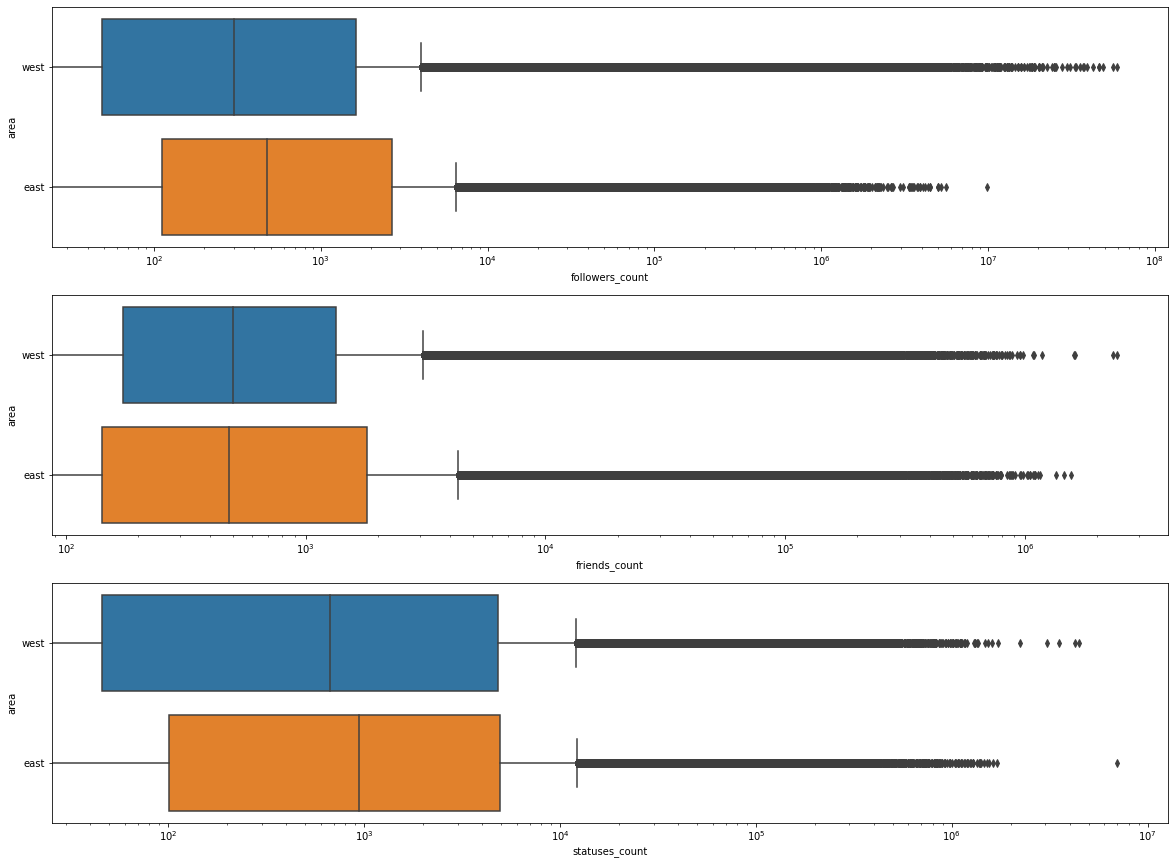

In [11]:
fig, ax = plt.subplots(3, 1, figsize = (20, 15))

ax[0].set(xscale="log")
sns.boxplot( x = 'followers_count', y = 'area', data = languages, ax = ax[0])

ax[1].set(xscale="log")
sns.boxplot( x = 'friends_count', y = 'area', data = languages, ax = ax[1])

ax[2].set(xscale="log")
sns.boxplot( x = 'statuses_count', y = 'area',  data = languages, ax = ax[2])

plt.show()

In [12]:
east_languages = languages[languages['area'] == 'east']
west_languages = languages[languages['area'] == 'west']
a = east_languages['followers_count'].tolist()
b = west_languages['followers_count'].tolist()
print(stats.kstest(a, b))

a = east_languages['friends_count'].tolist()
b = west_languages['friends_count'].tolist()
print(stats.kstest(a, b))

a = east_languages['statuses_count'].tolist()
b = west_languages['statuses_count'].tolist()
print(stats.kstest(a, b))


KstestResult(statistic=0.09266238118894404, pvalue=0.0)
KstestResult(statistic=0.07513387386339898, pvalue=0.0)
KstestResult(statistic=0.06134073529967235, pvalue=0.0)


In [13]:
ego_network = pd.read_csv("../Data/EgoNetworks.txt", sep = '\t')

In [19]:
ego_list = languages['ID'].tolist()
ego_network = ego_network[(ego_network['followerID'].isin(ego_list)) & (ego_network['followeeID'].isin(ego_list))]
ego_network.head(50)

,egoID,followerID,followeeID,lang1,lang2,same_lang
0,1,1,1573741,en,en,True
1,1,1,1662720,en,en,True
2,1,1,1968904,en,en,True
3,1,1,1970142,en,en,True
4,1,1,1970507,en,en,True
5,1,1,1971103,en,en,True
6,1,1,1971671,en,en,True
7,1,1,1974376,en,en,True
8,1,1,1975052,en,en,True
9,1,1,1975287,en,en,True


In [15]:
mapping_id_language = dict(zip(languages['ID'], languages['lang']))

def assign_lang(id):
    return mapping_id_language[id]

ego_network['lang1'] = ego_network['followerID'].apply(assign_lang)
ego_network['lang2'] = ego_network['followeeID'].apply(assign_lang)
ego_network['same_lang'] = np.where(ego_network['lang1'] == ego_network['lang2'], True, False)
ego_network['same_lang'].value_counts()

True     2977350
False     960550
Name: same_lang, dtype: int64

In [16]:
mapping_langauge = dict(zip(language_order, [i for i in range(0, 25)]))

rows, cols = (25, 25) 
connection = [[0 for i in range(cols)] for j in range(rows)] 
follow_pair = list(zip(ego_network['lang1'], ego_network['lang2']))

for i, v in enumerate(follow_pair):
    connection[mapping_langauge[follow_pair[i][0]]][mapping_langauge[follow_pair[i][1]]] += 1

connection_dataframe = pd.DataFrame(connection, columns = language_order, index = language_order)  
connection_dataframe.head(25)

,cs,fil,zh-tw,msa,da,fi,zh-cn,ca,sv,pl,...,it,fr,id,ru,tr,ja,ar,pt,es,en
cs,63,0,1,0,2,0,1,0,1,2,...,7,139,2,17,18,5,27,29,79,1135
fil,0,33,1,2,1,0,0,0,1,0,...,4,4,8,1,8,4,7,11,23,3073
zh-tw,0,1,254,0,0,1,14,0,0,1,...,4,11,9,82,2,249,3,6,37,1011
msa,0,0,0,2,0,0,0,0,0,0,...,1,0,18,1,2,0,7,4,7,963
da,0,0,0,0,120,1,1,0,8,0,...,8,20,1,7,15,2,9,26,61,1755
fi,0,0,0,0,0,1402,0,0,14,1,...,2,10,1,3,4,1,3,12,28,1055
zh-cn,0,0,13,0,1,0,136,0,7,0,...,9,25,6,19,12,125,10,37,60,2431
ca,0,0,0,0,0,0,0,1669,0,0,...,7,346,0,2,4,1,3,6,2400,647
sv,0,0,0,1,2,3,0,0,1236,2,...,10,27,5,10,41,6,18,25,99,2642
pl,0,0,1,0,1,0,0,0,5,425,...,16,23,6,13,14,2,18,55,147,3392


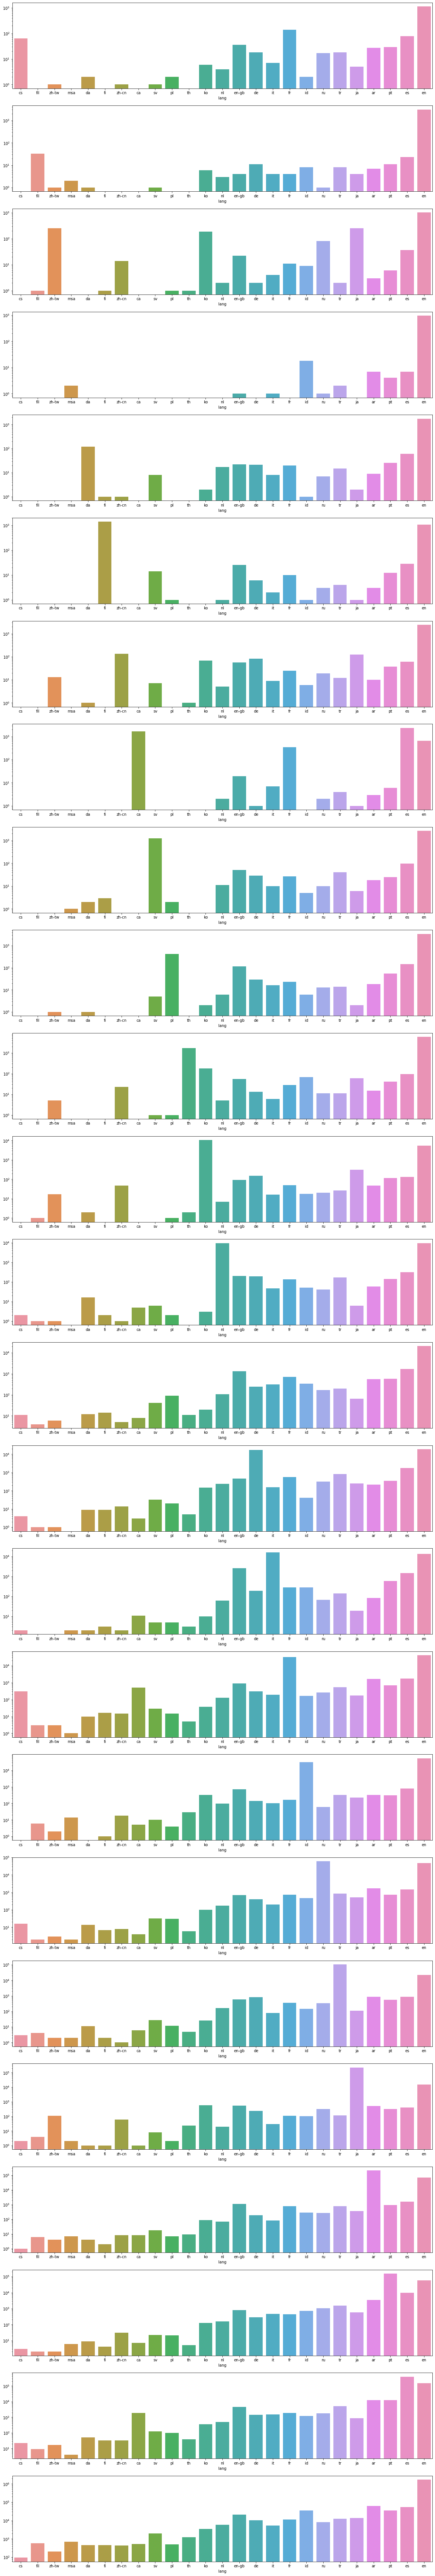

In [17]:
fig, ax = plt.subplots(25, 1, figsize = (20, 125))

for i in range(25):
    ax[i].set(yscale = 'log')
    sns.barplot(x = languages_stat.index, y = connection[i], ax = ax[i])

plt.show()